## Introduction

This notebook simulates freight trips and generates a freight population file. In this notebook, we assume LGVs represent last-mile deliveries to customers. We do not assume LGVs are used for other purposes such as construction, maintenance, or other purposes that require an LGV. We may want to revisit subpopulations for LGVs that have different behaviours.

The methodology follows the below steps: <br>
Estimate # of LGVs per hour **->** Assign # of Stops **->** Decide Location & Sequence of Stops **->** Determine Trip & Stop Duration

The following steps are undertaken:

1. Read, process, and plot data.
2. Input Assumptions
3. Create Samplers
4. Create Activity Model & Population
5. Validation

In [1]:
import pandas as pd
import geopandas as gp
from copy import deepcopy
import matplotlib
from matplotlib import pyplot as plt
import random
from datetime import date
import numpy as np
from shapely.geometry import Point, Polygon
import os


import pam
from pam.core import Population, Household, Person
from pam import read
from pam.plot.stats import plot_activity_times, plot_leg_times

import pam.samplers
from pam.samplers.basic import freq_sample
from pam.samplers.spatial import RandomPointSampler
from pam.samplers.facility import FacilitySampler
from pam.samplers import facility
from pam.samplers import tour

from pam import write
#from pam.activity import Plan, Activity, Leg
from pam.utils import minutes_to_datetime as mtdt
from pam.variables import END_OF_DAY
from pam.write import write_matsim, write_od_matrices, write_duration_benchmark, write_distance_benchmark, to_csv

# import warnings
# warnings.filterwarnings('ignore')

matplotlib.style.use('ggplot')

We keep a data register on S3. The data register is a csv file with information on each file input, such as:

    - a short description of each file,
    - the data source,
    - the path to the file on S3,
    - date created/updated,
    - a recommended variable name to be used in analysis
    - etc


In [2]:
output_path = './data/outputs'

## 1. Read, process, plot Data
Loading in necessary from data register. In this case, zones and freight facility data.

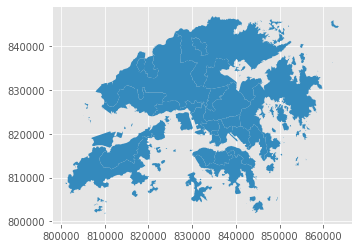

In [3]:
zones = gp.read_file('./data/example_data/hk_zones.geojson')
# we need to convert zones to a "m" grid crs such that can measure things in metres in matsim later
zones.to_crs("EPSG:2326", inplace=True)

# check consistency of zone encodings
zone_encodings = set(zones.NAME)

# ASSUMING this can be fixed as follows

class PartialDict(dict):
    def __missing__(self, key):
        return key

    
zone_mapping = PartialDict({
    'Fanling / Sheung Shui': 'Fanling / Shatin',
    'Yau Ma Tei': 'Yau Tsim'
})

zone_encodings = set(zones.NAME)
zones.set_index("NAME", inplace=True)
zones = zones.reset_index()

zones.plot()
plt.show()

In [4]:
# load facilities
facilities = gp.read_file('./data/example_data/hk_facilities_epsg_4326.geojson')
facilities.to_crs("EPSG:2326", inplace=True)
facilities.crs


<Derived Projected CRS: EPSG:2326>
Name: Hong Kong 1980 Grid System
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: China - Hong Kong - onshore and offshore.
- bounds: (113.76, 22.13, 114.51, 22.58)
Coordinate Operation:
- name: Hong Kong 1980 Grid
- method: Transverse Mercator
Datum: Hong Kong 1980
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

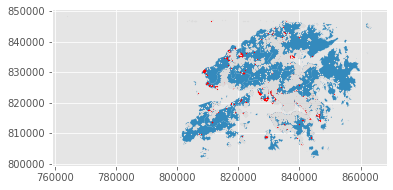

In [5]:
# Plot delivery locations (gainsboro) and depots (red). Note that some of the depot and delivery facilities are beyond the boundaries of our zones data.
fig, ax = plt.subplots()
zones.plot(ax=ax)
facilities[facilities['activity']=='depot'].plot(ax=ax, markersize=0.5, color='red')
facilities[facilities['activity']=='delivery'].plot(ax=ax, markersize=0.5, color='gainsboro')
plt.show()


In [6]:
facility_sampler = FacilitySampler(
    facilities=facilities,
    zones=zones,
    build_xml=True,
    fail=False,
    random_default=True
)

facility_sampler.activities

Joining facilities data to zones, this may take a while.
/var/folders/fg/4rbdps2s6ss9r2455xhzwd4sswl1dp/T/ipykernel_50852/930579154.py:1: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

Building sampler, this may take a while.


['delivery', 'depot']

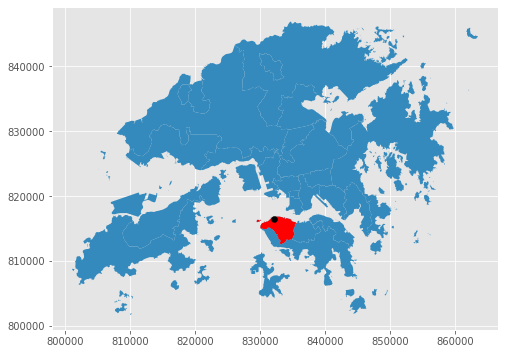

In [7]:
def plot_facility(zone_idx, activity):
    
    fig, ax = plt.subplots(figsize=(8,8))
    zones.plot(ax=ax)
    zones.loc[[zone_idx]].plot(color='red', ax=ax)
    
    facility_sampler.clear()
    point = facility_sampler.sample(zone_idx, activity)
    ax.scatter(point.x, point.y, color='black')
    plt.show()
    
plot_facility(random.choice(zones.FID), 'depot')

## 2. Input Assumptions

We create assumptions for the below six assumptions. The number of stops, first delivery of the day, and stop location all use a random sampler weighted on frequency.

1. **Number of Stops** <br>
    We've created a distribution based on this [research](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8569747&casa_token=RMr4Ks4RW4cAAAAA:deDYHpQBROY5lgm1qq8swaGhUfCandFV3dKr4Xpn-CghIHQ8Po-COmcm4NvvFKuUhGNJ7o0&tag=1). However, we need to validate with other datasets to determine if it is possible for deliveries to have 1 or 2 stops. The current assumption is a delivery has a minimum of 3 stops.

2. **Freight Tours & Delivery Time of Day** <br>
    Sourced from HK team [link](https://arup.sharepoint.com/:x:/s/IIA24236/EdHNl457U6pNrSD2d2k6HQUBYJwzmlPLkqoYXbApCpyO7w?e=R0X0tE), defined as Goods Vans that are not HGV or MGV.

    For time of day, we combine data from HK Traffic Flow Census Data [link](https://data.gov.hk/en-data/dataset/hk-td-tis_7-traffic-flow-census/resource/ef0f18ee-8ad4-4a4f-bf74-602c93a4e1f7) and the number of LGV Tours. Currently utilising Hong Kong Internal Cordon data as a reference. The LGV proporition is calculated [here](https://arup.sharepoint.com/:x:/s/IIA24236/EUGvbQ7q7StIi0DT6owCYFwBnKuUvo6zVHE-e8kP3_o70w?e=xDfnx0).


3. **Input Demand & Constraints** <br>
    Input demand is the density of depot origins and delivery destinations. Constraints are the distance between zones, expressed by an origin/destination dataframe.

#### 1. Number of Stops & Stop Sampler
Build a Stop Number distribution and corresponding sampler.

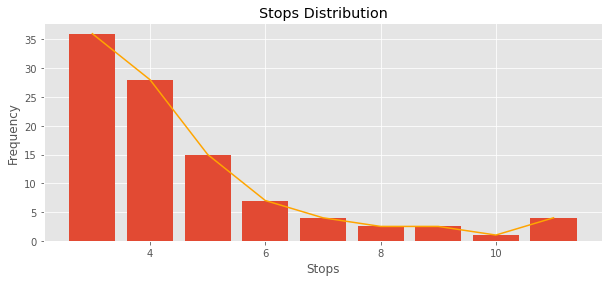

In [8]:
# Create Stop Distribution
bins = range(3,12)
pivots = {3: 36.0, 4: 28.0, 5: 15.0, 6: 7.0, 7: 4.0, 8: 2.5, 9: 2.5, 10: 1.0, 11: 4.0}
stops_dist = tour.CreateDistribution().build_distribution(bins=bins, pivots=pivots)
tour.CreateDistribution().plot_distribution(stops_dist, 'Stops Distribution', 'Stops', 'Frequency')

In [9]:
# Sample Number of stops
stop_sampler = tour.FrequencySampler(list(stops_dist.keys()), list(stops_dist.values()))
stop_sampler.sample()

8

#### 2. Freight Tours & Distribution
The number of freight tours is derived from the HK Goods Van matrix data.
The distribution of freight trips per hour is based on the HK Census counter data. However, there is not counting data from 11pm to 7am (overnight). Therefore, a simple linear model is applied for those hours via the CreateDistribution object.

In [10]:
# Set up freight params for both LGV and hgv movements

lgv_params = {'total':526945,
              'pivots': {7: 13.8, 8 :8.7, 9: 13.1, 10: 15.6, 11: 18.1, 12: 13.4, 13: 15.3, 14: 16, 15: 14.3, 16: 12.9, 17: 8.8, 18: 4.8, 19: 3.3, 20: 3.3, 21: 3, 22: 2.2},
              'agent_id': 'LGV',
              'agent_attributes': 'lgv'
              }

hgv_params = {'total':258541,
              'pivots': {7: 2.2, 8: 1.5, 9: 1.7, 10: 1.9, 11: 1.6, 12: 1.6, 13: 2.2, 14: 1.7, 15: 1.6, 16: 1.3, 17: 0.5, 18: 0.4, 19: 0.5, 20: 0.8, 21: 0.8, 22: 0.9},
              'agent_id': 'HGV',
              'agent_attributes': 'hgv'
              }

In [11]:
# We choose to create a population for LGV.
freight_params = lgv_params.copy()

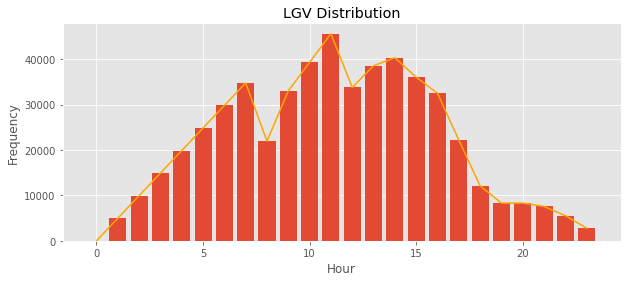

In [12]:
# Create LGV Distribution
bins = range(0,24)

freight_dist = tour.CreateDistribution().build_distribution(bins=bins, pivots=freight_params['pivots'], total=freight_params['total'])
tour.CreateDistribution().plot_distribution(freight_dist, f"{freight_params['agent_id']} Distribution", 'Hour', 'Frequency')

#### 3. Input Demand & Constraints
Calculate the density of depots and deliveries across all zones. Merge this with the zones table to obtain the geometry and calculate the distance between each zone.

In [13]:
# Input Demand, in this case defined as facility density location
depot_density, delivery_density = tour.InputDemand().facility_density(facilities=facilities,
                                                                      zones=zones,
                                                                      zone_id='FID',
                                                                      o_activity='depot',
                                                                      d_activity='delivery')

# Constraint, defined as distance between origin and destination centroids                                                                    
df_origin, df_destination, df_od = tour.InputDemand().od_distance(zones=zones)
df_od.head()

/Users/divya.sharma/Documents/repos/pam/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

/Users/divya.sharma/Documents/repos/pam/pam/samplers/tour.py:168: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,o_NAME,o_FID,o_T_11TPUSB_,o_geometry,o_centroid,d_NAME,d_FID,d_T_11TPUSB_,d_geometry,d_centroid,distance
0,Central & Western,0,1,"MULTIPOLYGON (((829651.946 816369.966, 829651....",POINT (833160.185 815129.854),Central & Western,0,1,"MULTIPOLYGON (((829651.946 816369.966, 829651....",POINT (833160.185 815129.854),0.000000
1,Wan Chai,1,2,"POLYGON ((837536.146 816437.751, 837535.651 81...",POINT (836897.178 814500.238),Central & Western,0,1,"MULTIPOLYGON (((829651.946 816369.966, 829651....",POINT (833160.185 815129.854),5.305526
2,Eastern,2,3,"POLYGON ((838988.870 817298.000, 838988.650 81...",POINT (841429.734 814958.427),Central & Western,0,1,"MULTIPOLYGON (((829651.946 816369.966, 829651....",POINT (833160.185 815129.854),11.579856
3,Southern,3,4,"MULTIPOLYGON (((844852.679 807550.815, 844853....",POINT (838849.888 811653.372),Central & Western,0,1,"MULTIPOLYGON (((829651.946 816369.966, 829651....",POINT (833160.185 815129.854),9.334824
4,Yau Tsim,4,5,"POLYGON ((835161.305 819974.377, 835154.412 81...",POINT (835411.012 818536.496),Central & Western,0,1,"MULTIPOLYGON (((829651.946 816369.966, 829651....",POINT (833160.185 815129.854),5.716293


## 3. Samplers

In [14]:
# test sampling an hour from this distribution
hour_sampler = tour.FrequencySampler(list(freight_dist.keys()), list(freight_dist.values()))
hour_sampler.sample()

7

In [15]:
# test same a minute
minute_sampler = tour.FrequencySampler(range(60))
minute_sampler.sample()

8

In [16]:
# Sample Number of stops
stop_sampler = tour.FrequencySampler(list(stops_dist.keys()), list(stops_dist.values()))
stop_sampler.sample()

7

In [17]:
# Sample origin based on density table
ozone_sampler = tour.FrequencySampler(list(depot_density['FID']), list(depot_density['density']))
ozone_sampler.sample()

13

## 4. Activity Modeller

Assumptions and samplers are applied to build a population of activity plans.

Key assumptions of note:

- we take total demand from the hourly distribution and divide by 2 - this assumes a reciprocating return trip
- we create 2 activity types: depot and delivery
- we model depot departure time by sampling from hourly demand
- if a delivery end is estimated to go beyond 24 hours, we have the driver return to the depot instead.

Activities are encoded as "car". Subpopulation is encoded as "lgv" or "hgv".

A plan is modelled by the following functions:
- tour_activity: Adds the activity of a new delivery
- tour_leg: Adds the leg of travel to the new delivery
- return_depot: combines the two above to return from the last delivery to the origin depot

### Population Parameters

In [18]:
#Factor to scale trips (To better match validation counts when needed)
factor = 1 #0.70

#List
#samples = [0.0001]
samples = [0.01]
#samples = [0.10]

# Set Distance threshold, in this case arbitrarily set to median distance of od dataframe.
dist_threshold = df_od.distance.median()

# Set activity parameters
speed = 40000/3600 # 50km/hr
maxi = 3600
mini = 600


# #create export directory if it doesn't exist
# if os.path.isdir(output_path)==False:
#     os.mkdir(output_path)

In [19]:
# used for fnames
today = date.today().strftime('%d%b%y')
today

'05May22'

In [20]:
#### Sample Agents
# Considered bundling this into the tour script, but decided too many variables would need to be passed. This felt like over-engineering.
def sample_agents(size):
    
    facility_sampler.clear()
    population = Population()
    
    # make below into an LGV/HGV function: freight_sampler.
    for i in range(size):

        agent_id = f"{freight_params['agent_id']}_{i}"

        # have to add hh to keep pam happy even though makes no sense in this case
        # might try to abstract this away in future
        hh = Household(agent_id)
        
        agent = Person(
            agent_id,
            attributes={
                'subpopulation': freight_params['agent_attributes'],
                'CarType': freight_params['agent_attributes'],
                'CarCO2': freight_params['agent_attributes']
            }
        )
        
        hh.add(agent)
        population.add(hh)

        hour = hour_sampler.sample()
        minute = minute_sampler.sample()

        o_zone = random.choice(zones.FID)
        o_loc = facility_sampler.sample(o_zone, 'depot')

        if freight_params['agent_id']=='LGV':
            stops = stop_sampler.sample()
        else:
            stops = 1

        d_zone, d_loc = tour.TourSequence().stop_sequence(stops=stops,
                                                          d_density=delivery_density, 
                                                          o_zone=o_zone, 
                                                          df_od=df_od, 
                                                          dist_threshold=dist_threshold, 
                                                          dist_id='distance', 
                                                          zone_id='FID',
                                                          facility_sampler=facility_sampler,
                                                          o_loc=o_loc,
                                                          d_activity='delivery')

        time_params = {'hour':hour, 'minute':minute}
        end_tm = tour.TourPlan().tour_activity(agent=agent, k=1, zone=o_zone, loc=o_loc, activity_type='depot', time_params=time_params)

        # Build a Tour Plan utilising ActivityDuration and TourPlan objects.

        for k in range(stops):
            # Currently, we assume stop duration ranges from 10 minutes, 100% of the journey time, or 60 minutes.
            stop_duration, start_tm, end_tm = tour.ActivityDuration().activity_duration(o_loc, d_loc[k], end_tm, speed, maxi, mini)
            if mtdt(end_tm) > END_OF_DAY:
                #print(f'End of Day Agent {agent}, return to depot')
                break
            elif k == 0:
                end_tm = tour.TourPlan().tour_leg(agent=agent, k=k, o_zone=o_zone, o_loc=o_loc, d_zone=d_zone, d_loc=d_loc[k], start_tm=start_tm, end_tm=end_tm)

                time_params = {'end_tm':end_tm, 'stop_duration':stop_duration}
                end_tm = tour.TourPlan().tour_activity(agent=agent, k=k, zone=d_zone, loc=d_loc[k], activity_type='delivery', time_params=time_params)
            else: 
                end_tm = tour.TourPlan().tour_leg(agent=agent, k=k, o_zone=d_zone, o_loc=d_loc[k-1], d_zone=d_zone, d_loc=d_loc[k], start_tm=start_tm, end_tm=end_tm)

                time_params = {'end_tm':end_tm, 'stop_duration':stop_duration}
                end_tm = tour.TourPlan().tour_activity(agent=agent, k=k, zone=d_zone, loc=d_loc[k], activity_type='delivery', time_params=time_params)
        
        end_tm = tour.TourPlan().return_depot(agent=agent, k=stops, o_zone=o_zone, o_loc=o_loc, d_zone=d_zone, d_loc=d_loc[stops-1], end_tm=end_tm, speed=speed)
        
    return population


In [21]:
# Function to build population 

def build_population(sample, factor):
    population = sample_agents(int(factor * int(freight_params['total'] * sample)))
    
    return population

In [22]:
# Build + Crop + Write Population for samples
for s in samples:
    
    #build
    population = build_population(s, factor)
        
    #Crop and Validate Plans
    population.fix_plans()
    population.validate()

    # Write to Disk
    xml_comment = f"prelim {s*100}% {freight_params['agent_id']} {today}"
    output_path = os.path.join(output_path)
    #create export directory if it doesn't exist
    # if os.path.isdir(output_path)==False:
    #     os.mkdir(output_path)
    
    write_matsim(
        population,
        os.path.join(output_path, "plans.xml"),
        os.path.join(output_path, "attributes.xml"),
        comment=xml_comment
    )

    population.to_csv(output_path, crs = "EPSG:2326", to_crs="EPSG:4326")
    # ignore all the "failed to find home" logging (it is not relevant and will be removed in future)

    facility_sampler.write_facilities_xml(
       os.path.join(output_path, "facilities.xml"),
       comment=xml_comment
    )

Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending 

## 5. Validation

Person: LGV_1547
{'subpopulation': 'lgv', 'CarType': 'lgv', 'CarCO2': 'lgv', 'hid': 'LGV_1547'}
0:	Activity(1 act:depot, location:POINT (832934.9058976148 815234.4810671074), time:00:00:00 --> 02:15:00, duration:2:15:00)
1:	Leg(1 mode:car, area:POINT (832934.9058976148 815234.4810671074) --> POINT (837924.5256712876 818535.833019277), time:02:15:00 --> 02:27:00, duration:0:12:00)
2:	Activity(2 act:delivery, location:POINT (837924.5256712876 818535.833019277), time:02:27:00 --> 02:39:00, duration:0:12:00)
3:	Leg(2 mode:car, area:POINT (837924.5256712876 818535.833019277) --> POINT (836258.1177741699 814928.6578438056), time:02:39:00 --> 02:46:00, duration:0:07:00)
4:	Activity(3 act:delivery, location:POINT (836258.1177741699 814928.6578438056), time:02:46:00 --> 02:56:00, duration:0:10:00)
5:	Leg(3 mode:car, area:POINT (836258.1177741699 814928.6578438056) --> POINT (844779.1999922175 820030.6831626187), time:02:56:00 --> 03:22:00, duration:0:26:00)
6:	Activity(4 act:delivery, location:

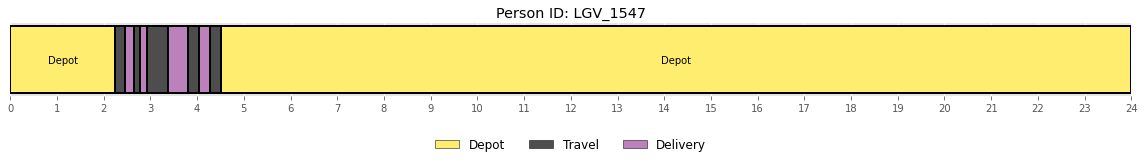

Person: LGV_145
{'subpopulation': 'lgv', 'CarType': 'lgv', 'CarCO2': 'lgv', 'hid': 'LGV_145'}
0:	Activity(1 act:depot, location:POINT (829582.8937852341 823249.1230574924), time:00:00:00 --> 13:28:00, duration:13:28:00)
1:	Leg(1 mode:car, area:POINT (829582.8937852341 823249.1230574924) --> POINT (835687.4369825169 819151.7381075476), time:13:28:00 --> 13:43:00, duration:0:15:00)
2:	Activity(2 act:delivery, location:POINT (835687.4369825169 819151.7381075476), time:13:43:00 --> 13:58:00, duration:0:15:00)
3:	Leg(2 mode:car, area:POINT (835687.4369825169 819151.7381075476) --> POINT (835269.5009574891 820664.4732639967), time:13:58:00 --> 14:11:00, duration:0:13:00)
4:	Activity(3 act:delivery, location:POINT (835269.5009574891 820664.4732639967), time:14:11:00 --> 14:24:00, duration:0:13:00)
5:	Leg(3 mode:car, area:POINT (835269.5009574891 820664.4732639967) --> POINT (837768.5005068099 826138.4653692571), time:14:24:00 --> 14:42:00, duration:0:18:00)
6:	Activity(4 act:delivery, locatio

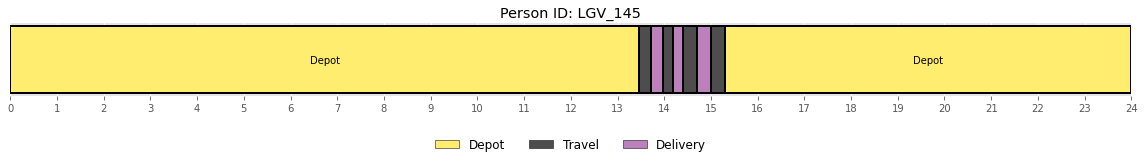

Person: LGV_947
{'subpopulation': 'lgv', 'CarType': 'lgv', 'CarCO2': 'lgv', 'hid': 'LGV_947'}
0:	Activity(1 act:depot, location:POINT (839588.5904002379 820585.0996456804), time:00:00:00 --> 17:48:00, duration:17:48:00)
1:	Leg(1 mode:car, area:POINT (839588.5904002379 820585.0996456804) --> POINT (836296.3353071866 819752.4728972076), time:17:48:00 --> 17:55:00, duration:0:07:00)
2:	Activity(2 act:delivery, location:POINT (836296.3353071866 819752.4728972076), time:17:55:00 --> 18:05:00, duration:0:10:00)
3:	Leg(2 mode:car, area:POINT (836296.3353071866 819752.4728972076) --> POINT (834578.3433269454 814063.2881500048), time:18:05:00 --> 18:22:00, duration:0:17:00)
4:	Activity(3 act:delivery, location:POINT (834578.3433269454 814063.2881500048), time:18:22:00 --> 18:39:00, duration:0:17:00)
5:	Leg(3 mode:car, area:POINT (834578.3433269454 814063.2881500048) --> POINT (832342.7864039852 816458.9295852882), time:18:39:00 --> 18:56:00, duration:0:17:00)
6:	Activity(4 act:delivery, locatio

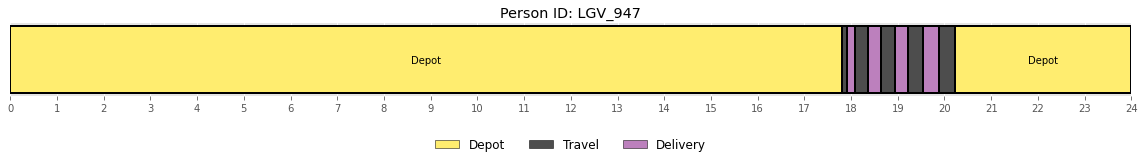

In [23]:
for i in range(3):
    p = population.random_person()
    p.plot()
    p.print()
    plt.show()

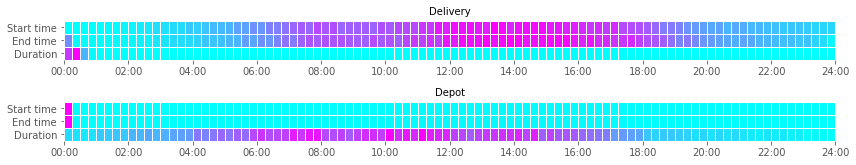

In [24]:
from pam.plot.stats import plot_activity_times, plot_leg_times
fig = plot_activity_times(population)
plt.show()

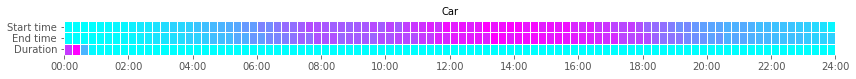

In [25]:
fig = plot_leg_times(population)
plt.show()

In [26]:
trips = pd.read_csv(os.path.join(output_path,"legs.csv"))

def get_hour(dt):
    return int(dt.split(" ")[1].split(":")[0])

trips["start_hour"] = trips["tst"].apply(get_hour)
trips.head()

,Unnamed: 0,pid,hid,freq,ozone,dzone,purp,origin activity,destination activity,mode,seq,tst,tet,duration,start_hour
0,0,LGV_0,LGV_0,NaN,20,24,NaN,depot,delivery,car,1,1900-01-01 13:28:00,1900-01-01 14:03:00,0:35:00,13
1,1,LGV_0,LGV_0,NaN,24,24,NaN,delivery,delivery,car,2,1900-01-01 14:38:00,1900-01-01 15:00:00,0:22:00,14
2,2,LGV_0,LGV_0,NaN,24,24,NaN,delivery,delivery,car,3,1900-01-01 15:22:00,1900-01-01 15:44:00,0:22:00,15
3,3,LGV_0,LGV_0,NaN,24,20,NaN,delivery,depot,car,4,1900-01-01 16:06:00,1900-01-01 16:28:00,0:22:00,16
4,4,LGV_1,LGV_1,NaN,11,22,NaN,depot,delivery,car,1,1900-01-01 17:23:00,1900-01-01 17:52:00,0:29:00,17


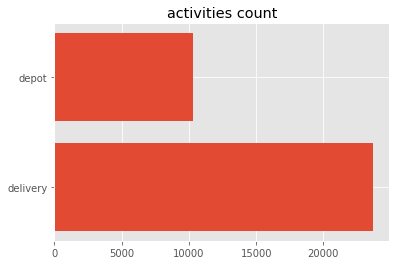

In [27]:
df_activity = pd.read_csv(os.path.join(output_path, "activities.csv"))
totals = df_activity.activity.value_counts()
plt.barh(totals.index, totals)
plt.title("activities count")
plt.show()

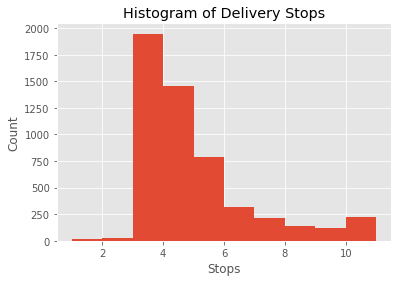

In [28]:
matplotlib.style.use('ggplot')

plot_data = df_activity[df_activity['activity']=='delivery'].groupby(['pid']).agg({'activity':'count'}).reset_index()
g = plt.hist(x = 'activity', data = plot_data)

plt.title('Histogram of Delivery Stops')
plt.xlabel('Stops')
plt.ylabel('Count')

plt.show()

In [29]:
delivery_count = df_activity[df_activity['activity']=='delivery'].groupby(['pid']).agg({'activity':'count'}).reset_index()
depot_count = df_activity[df_activity['activity']=='depot'].groupby(['pid']).agg({'activity':'count'}).reset_index()
print(f'Ratio of deliveries to depots {delivery_count.activity.sum()/depot_count.activity.sum()}')
delivery_count.describe()

Ratio of deliveries to depots 2.29821670866447


,activity
count,5262.000000
mean,4.506461
std,1.957896
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,11.000000


In [30]:
write_od_matrices(population, path = output_path)
od_matrices = pd.read_csv(os.path.join(output_path, "total_od.csv"))  # we should change this method to be consistent with other - ie return a dataframe

pop_o = pd.DataFrame({'FID': od_matrices['Origin'],
                     'o_trip': od_matrices.drop('Origin', axis=1).sum(axis=1)})

pop_d = pd.DataFrame({'FID': od_matrices.index,
                     'd_trip': od_matrices.drop(['Origin'], axis=1).sum(axis=0)})
pop_d['FID'] = pop_d.index.astype(int)


In [31]:
# Create a dataframe to plot od trips and compare against facility density and flows density.
pop_od = zones.copy()

# Merge in trips information
pop_od = pd.merge(pop_od, pop_o, left_on = 'FID', right_on = 'FID', how = 'left')
pop_od = pd.merge(pop_od, pop_d, left_on = 'FID', right_on = 'FID', how = 'left')

# Merge in density information
pop_od = pd.merge(pop_od, depot_density, left_on = 'FID', right_on = 'FID', how = 'left')
pop_od.rename(columns={'activity':'depot_activity','density':'depot_density'}, inplace=True)
pop_od = pd.merge(pop_od, delivery_density, left_on = 'FID', right_on = 'FID', how = 'left')
pop_od.rename(columns={'activity':'delivery_activity','density':'delivery_density'}, inplace=True)

pop_od.head()

,NAME,FID,T_11TPUSB_,geometry,o_trip,d_trip,depot_activity,depot_density,delivery_activity,delivery_density
0,Central & Western,0,1,"MULTIPOLYGON (((829651.946 816369.966, 829651....",1104,1107,37,0.012466,2524,0.036817
1,Wan Chai,1,2,"POLYGON ((837536.146 816437.751, 837535.651 81...",1065,1062,14,0.004717,2566,0.037429
2,Eastern,2,3,"POLYGON ((838988.870 817298.000, 838988.650 81...",868,867,116,0.039084,2397,0.034964
3,Southern,3,4,"MULTIPOLYGON (((844852.679 807550.815, 844853....",1171,1177,98,0.033019,2799,0.040828
4,Yau Tsim,4,5,"POLYGON ((835161.305 819974.377, 835154.412 81...",1222,1221,7,0.002358,2642,0.038538


Text(0.5, 1.0, 'Trips from Depot (origin)')

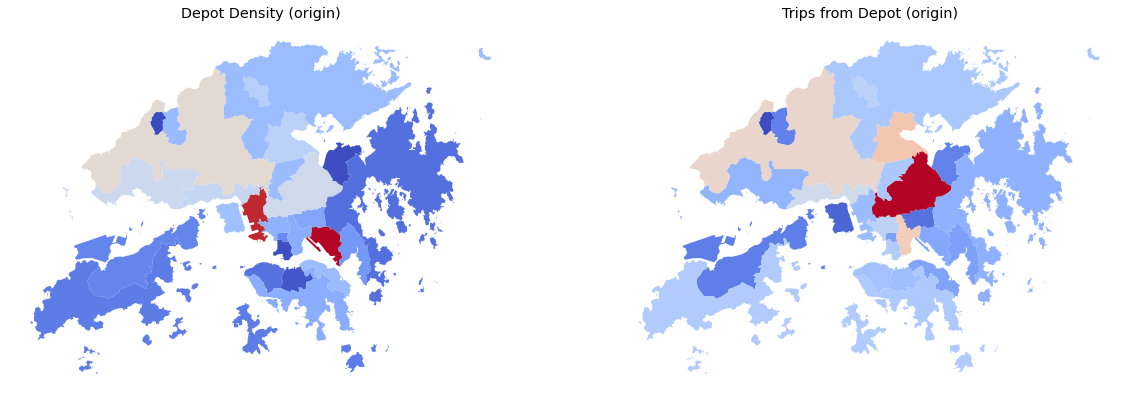

In [32]:
# Plot density, trips, and flows by zone.

fig, ax = plt.subplots(1, 2, figsize=(20,10))

pop_od.plot('depot_density', ax=ax[0], cmap='coolwarm')
ax[0].axis('off')
ax[0].set_title('Depot Density (origin)')

pop_od.plot('o_trip', ax=ax[1], cmap='coolwarm')
ax[1].axis('off')
ax[1].set_title('Trips from Depot (origin)')

The Origin Trips distribution does not seem to align well with the density of the depots. 

Text(0.5, 1.0, 'Frequency of Origin Trips by Zone ID')

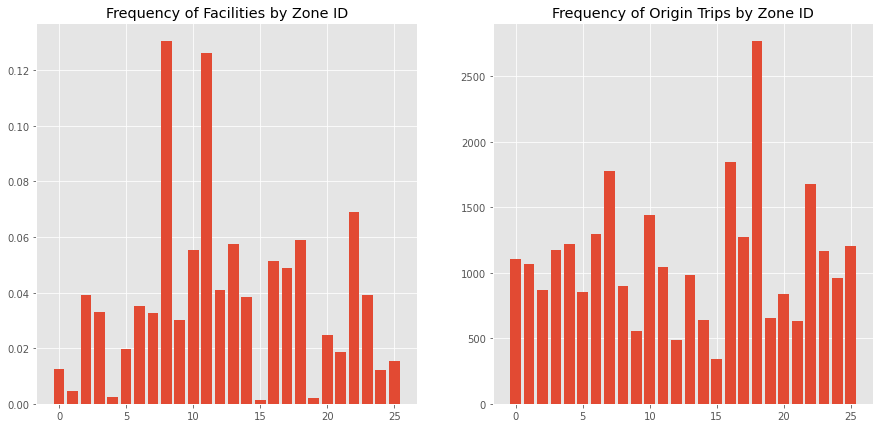

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))

ax[0].bar(x='FID', height='depot_density', data = pop_od)
ax[0].set_title('Frequency of Facilities by Zone ID')

ax[1].bar(x='FID', height='o_trip', data = pop_od)
ax[1].set_title('Frequency of Origin Trips by Zone ID')

We are seeing under-representation in the far east corner of Hong Kong, this could be due to limiting distance from origin.

Text(0.5, 1.0, 'Trips to Delivery (destination)')

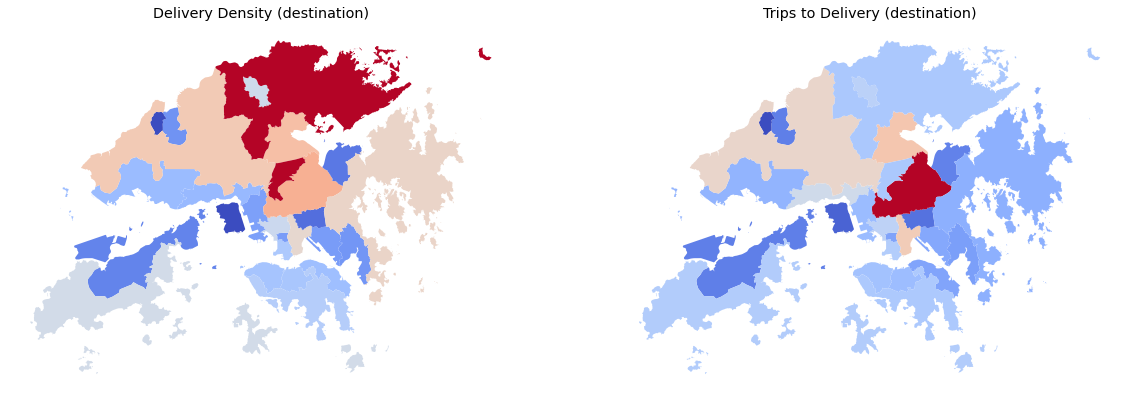

In [34]:
# Plot density, trips, and flows by zone.

fig, ax = plt.subplots(1, 2, figsize=(20,10))

pop_od.plot('delivery_density', ax=ax[0], cmap='coolwarm')
ax[0].axis('off')
ax[0].set_title('Delivery Density (destination)')

pop_od.plot('d_trip', ax=ax[1], cmap='coolwarm')
ax[1].axis('off')
ax[1].set_title('Trips to Delivery (destination)')

Text(0.5, 1.0, 'Frequency of Destination Trips by Zone ID')

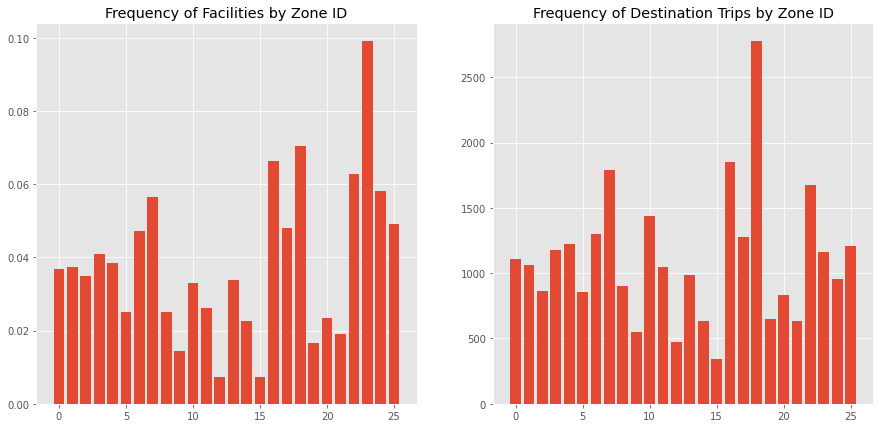

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))

ax[0].bar(x='FID', height='delivery_density', data = pop_od)
ax[0].set_title('Frequency of Facilities by Zone ID')

ax[1].bar(x='FID', height='d_trip', data = pop_od)
ax[1].set_title('Frequency of Destination Trips by Zone ID')

In [36]:
# write_matsim(
#         population,
#         os.path.join(output_path, "population.xml"),
#         os.path.join(output_path, "attributes.xml"),# Note the version12 don't have attributes
#         version=12
#     )